<h1>Contents</h1>

# I. Dataset Preparation

## 1. Import library

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
files = {
    "application_train": r"dseb63_application_train.csv",
    "application_test": r"dseb63_application_test.csv",
    "bureau": r"dseb63_bureau.csv",
    "bureau_balance": r"dseb63_bureau_balance.csv",
    "previous_application": r"dseb63_previous_application.csv",
    "POS_CASH_balance": r"dseb63_POS_CASH_balance.csv",
    "installments_payments": r"dseb63_installments_payments.csv",
    "credit_card_balance": r"dseb63_credit_card_balance.csv"
}

# Load all files into a dictionary
data = {}
for key, file in files.items():
    data[key] = pd.read_csv(file)
    print(f"{key} shape: {data[key].shape}")

application_train shape: (246009, 123)
application_test shape: (61502, 122)
bureau shape: (1465325, 17)
bureau_balance shape: (27299925, 3)
previous_application shape: (1413701, 37)
POS_CASH_balance shape: (8543375, 8)
installments_payments shape: (7744758, 8)
credit_card_balance shape: (3227965, 23)


In [3]:
data['application_train'].drop(columns = 'Unnamed: 0', inplace = True)
data['application_test'].drop(columns = 'Unnamed: 0', inplace = True)

## 2. Function

In [4]:
# Function to print unique data types
def print_dtypes(df, dataset_name):
    print(f"\nUnique data types in {dataset_name}:")
    print(df.dtypes.value_counts())

# Function to check for missing values
def check_missing_values(df, dataset_name):
    missing_values = df.isnull().sum()
    missing_columns = missing_values[missing_values > 0].sort_values(ascending=False)  # Only show columns with missing values
    if not missing_columns.empty:
        print(f"\nMissing values in {dataset_name}:\n{missing_columns}")
    else:
        print(f"\nNo missing values in {dataset_name}.")

# Function to check the percentage of missing values
def check_missing_percentage(df):
    missing_percentage = 100 * df.isnull().sum() / len(df)
    missing_columns = missing_percentage[missing_percentage > 0].sort_values(ascending=False) 
    return missing_columns

# Function to handle missing values
def handle_missing_values(df):
    # Drop columns with more than 80% missing values
    threshold = 0.8
    cols_to_drop = df.columns[df.isnull().mean() > threshold]
    df.drop(columns=cols_to_drop, inplace=True)
    print(f"Dropped columns with more than {threshold*100}% missing values: {list(cols_to_drop)}")
    return df


def bar_hor(df, col, title, color, w=None, h=None, lm=0, limit=100, return_trace=False, rev=False, xlb = False):
    cnt_srs = df[col].value_counts()
    yy = cnt_srs.head(limit).index[::-1] 
    xx = cnt_srs.head(limit).values[::-1] 
    if rev:
        yy = cnt_srs.tail(limit).index[::-1] 
        xx = cnt_srs.tail(limit).values[::-1] 
    if xlb:
        trace = go.Bar(y=xlb, x=xx, orientation = 'h', marker=dict(color=color))
    else:
        trace = go.Bar(y=yy, x=xx, orientation = 'h', marker=dict(color=color))
    if return_trace:
        return trace 
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def bar_hor_noagg(x, y, title, color, w=None, h=None, lm=0, limit=100, rt=False):
    trace = go.Bar(y=x, x=y, orientation = 'h', marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


def bar_ver_noagg(x, y, title, color, w=None, h=None, lm=0, rt = False):
    trace = go.Bar(y=y, x=x, marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def gp(col, title):
    df1 = data['application_train'][data['application_train']["TARGET"] == 1]
    df0 = data['application_train'][data['application_train']["TARGET"] == 0]
    a1 = df1[col].value_counts()
    b1 = df0[col].value_counts()
    
    total = dict(data['application_train'][col].value_counts())
    x0 = a1.index
    x1 = b1.index
    
    y0 = [float(x)*100 / total[x0[i]] for i,x in enumerate(a1.values)]
    y1 = [float(x)*100 / total[x1[i]] for i,x in enumerate(b1.values)]

    trace1 = go.Bar(x=a1.index, y=y0, name='Target : 1', marker=dict(color="#96D38C"))
    trace2 = go.Bar(x=b1.index, y=y1, name='Target : 0', marker=dict(color="#FEBFB3"))
    return trace1, trace2 

# II. Data exploration

## 1. Application Train

Application data consists of static data for all applications and every row represents one loan.

In [5]:
data['application_train'].head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR
0,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.796,0.0605,0.08,0.0345,0.2917,0.3333,0.013,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.804,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,278621
1,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,139008
2,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,138348
3,0,Cash loans,M,N,Y,

There are total 246,009 rows which contains the information of loans and there are 122 variables. 

The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.


### 1.1. Distribution of Target Variable 

The target variable defines weather the loan was repayed or not. Let us look at what is the distribution of loan repayment in the training dataset. 

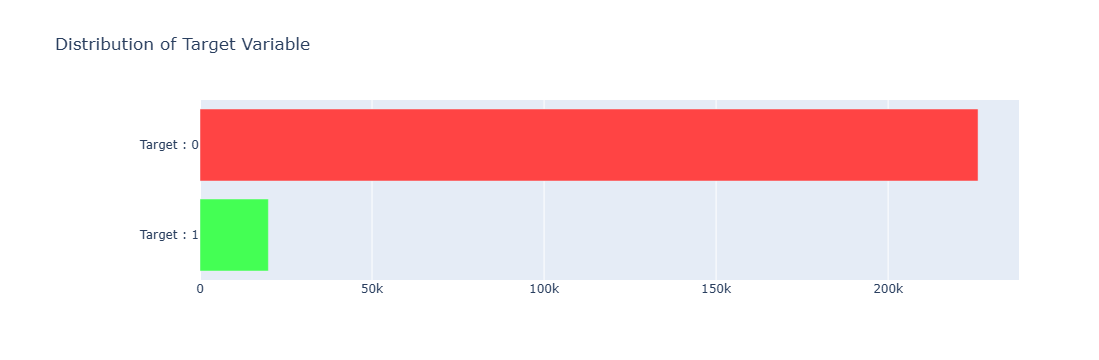

In [6]:
# Target Variable Distribution 
bar_hor(data['application_train'], "TARGET", "Distribution of Target Variable" , ["#44ff54", '#ff4444'], h=350, w=600, lm=200, xlb = ['Target : 1','Target : 0'])

In [7]:
percentage_of_0 = (len(data['application_train'][data['application_train']['TARGET'] == 0]) / len((data['application_train']))) * 100 
count_0 = len(data['application_train'][data['application_train']['TARGET'] == 0])
count_1 = len(data['application_train'][data['application_train']['TARGET'] == 1])

The target variable is slightly imbalance with the majority of loans has the target equals to 0 which indicates that individuals did not had any problems in paying installments in given time. There are about 91% loans which is equal to about 226K with target = 0, While only 9% of the total loans (about 19K applicants) in this dataset involved the applicants having problems in repaying the loan / making installments.  

### 1.2 Gender Type of Applicants 

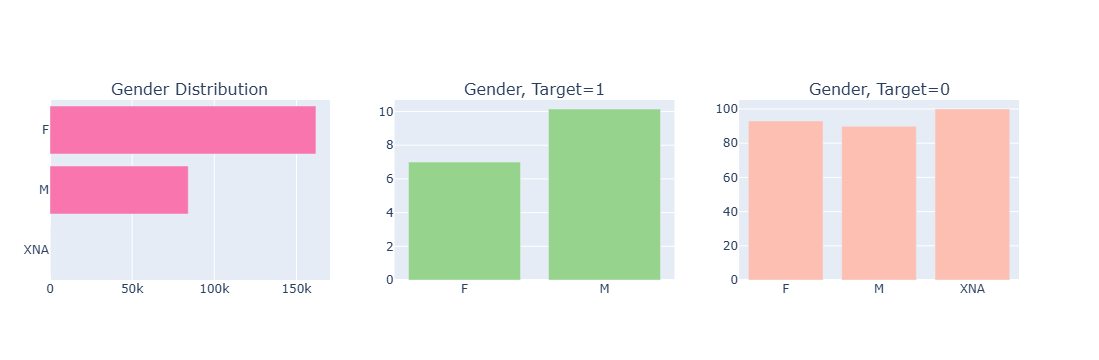

In [8]:
tr0 = bar_hor(data['application_train'], "CODE_GENDER", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('CODE_GENDER', 'Distribution of Target with Applicant Gender')

fig = make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["Gender Distribution" , "Gender, Target=1" ,"Gender, Target=0"])
fig.append_trace(tr0, 1, 1)
fig.append_trace(tr1, 1, 2)
fig.append_trace(tr2, 1, 3)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50))   
iplot(fig)

In the applicant's data women have applied for a larger majority of loans which is almost the double as the men. In total, there are about 161,856 loan applications filed by females in contrast to about 84,150 applications filed by males. However, a larger percentage (about 10% of the total) of men had the problems in paying the loan within time as compared to women applicants (about 7%). 

### 1.3 Family Status of Applicants

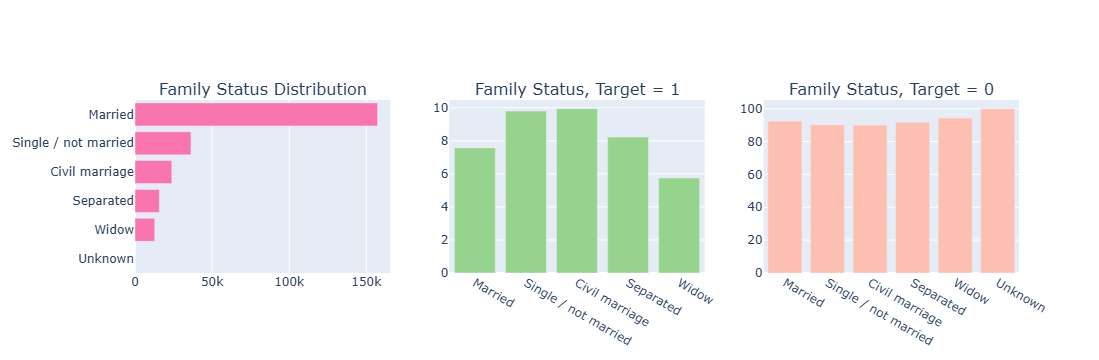

In [9]:
tr0 = bar_hor(data['application_train'], "NAME_FAMILY_STATUS", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('NAME_FAMILY_STATUS', 'Distribution of Target with Applicant Gender')

fig = make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["Family Status Distribution" , "Family Status, Target = 1" ,"Family Status, Target = 0"])
fig.append_trace(tr0, 1, 1)
fig.append_trace(tr1, 1, 2)
fig.append_trace(tr2, 1, 3)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120))
iplot(fig)

Married people have applied for a larger number of loan applications about 157K, However, people having Civil Marriage has the highest percentage (about 9.9%) of loan problems and challenges. 

### 1.4. Does applicants own Real Estate or Car ?

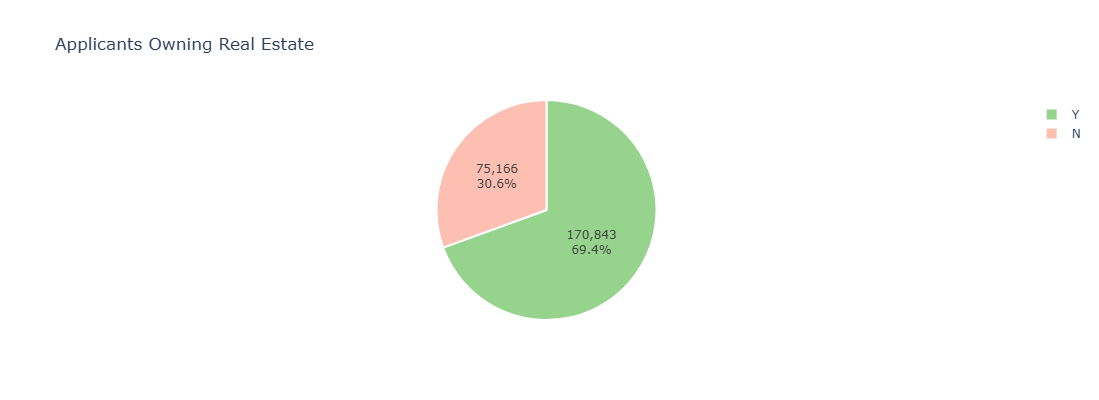

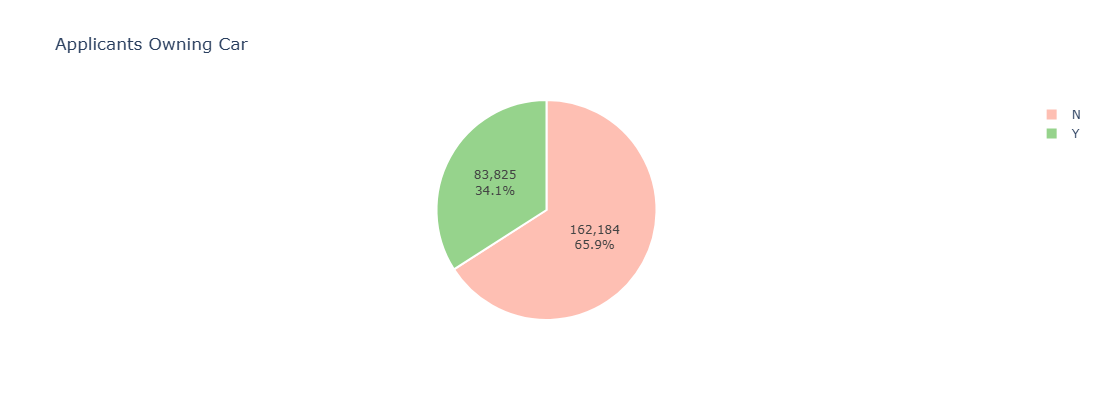

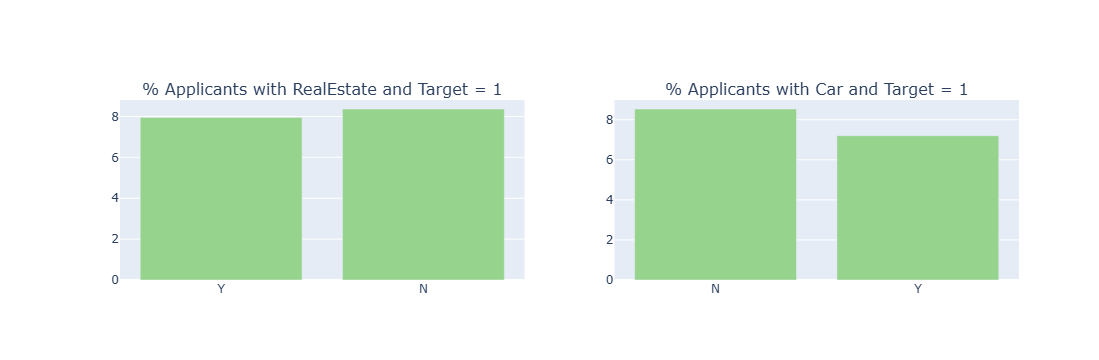

In [10]:
## real estate 
t = data['application_train']['FLAG_OWN_REALTY'].value_counts()
labels = t.index
values = t.values
colors = ['#96D38C','#FEBFB3']
trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value+percent',
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))
layout = go.Layout(title='Applicants Owning Real Estate', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


t = data['application_train']['FLAG_OWN_CAR'].value_counts()
labels = t.index
values = t.values
colors = ['#FEBFB3','#96D38C']
trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value+percent',
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))
layout = go.Layout(title='Applicants Owning Car', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


tr1, tr2 = gp('FLAG_OWN_REALTY', 'Applicants Owning Real Estate wrt Target Variable')
tr3, tr4 = gp('FLAG_OWN_CAR', 'Applicants Owning Car wrt Target Variable')
fig = make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["% Applicants with RealEstate and Target = 1", "% Applicants with Car and Target = 1"])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr3, 1, 2)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig)

 About 69.4% of the applicants own Real Estate, while only 34.1% of applicants own Car who had applied for the loan in the past years. However, a higher percentage of people having payment difficulties was observed with applicants which did not owned Car or which did not owned Real Estate. 

### 1.5 Suite Type and Income Type of Applicants 

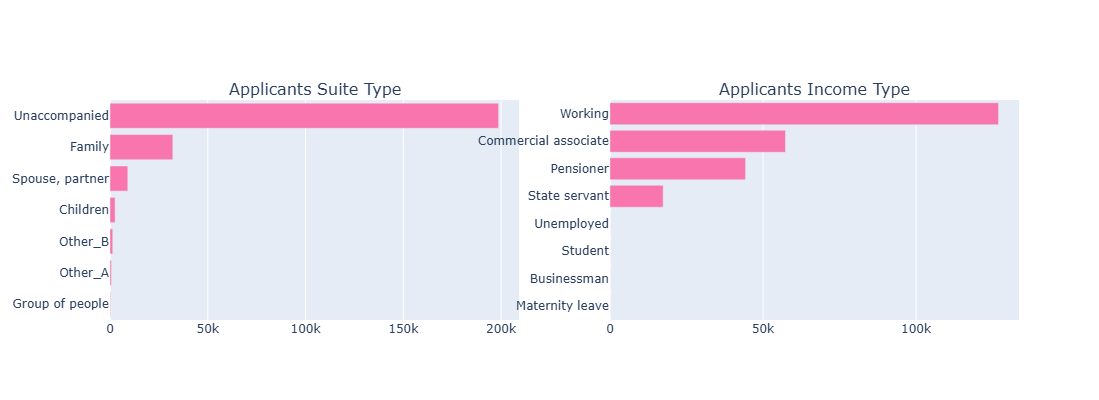

In [11]:
tr0 = bar_hor(data['application_train'], "NAME_TYPE_SUITE", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1 = bar_hor(data['application_train'], "NAME_INCOME_TYPE", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)

fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Suite Type' , 'Applicants Income Type'])
fig.append_trace(tr0, 1, 1)
fig.append_trace(tr1, 1, 2)
fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig)

> Top 3 Type Suites which applies for loan are the houses which are:  
- Unaccompanined (about 198K applicants) 
- Family (about 32K applicants)  
- Spouse, partner (about 9K applicants)    
> The income type of people who applies for loan include about 8 categroes, top ones are : 
- Working Class (126K)
- Commercial Associate (57K)
- Pensiner (44K)

### <a id="1.5.1">1.5.1 How does Target Varies with Suite and Income Type of Applicants</a>

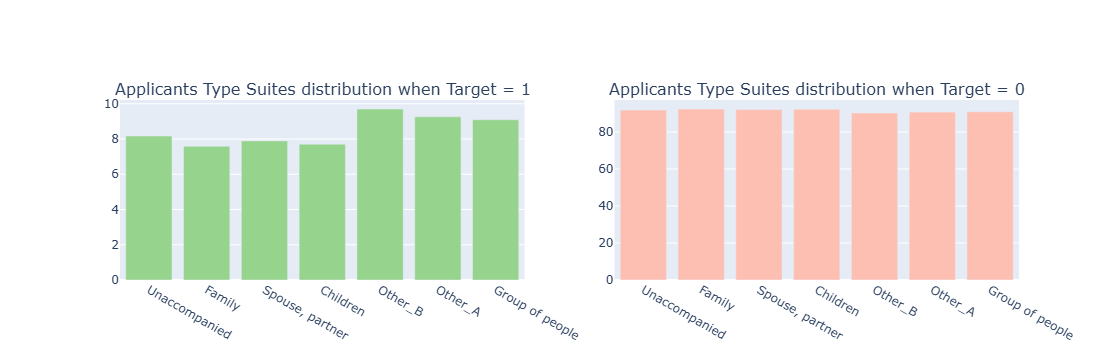

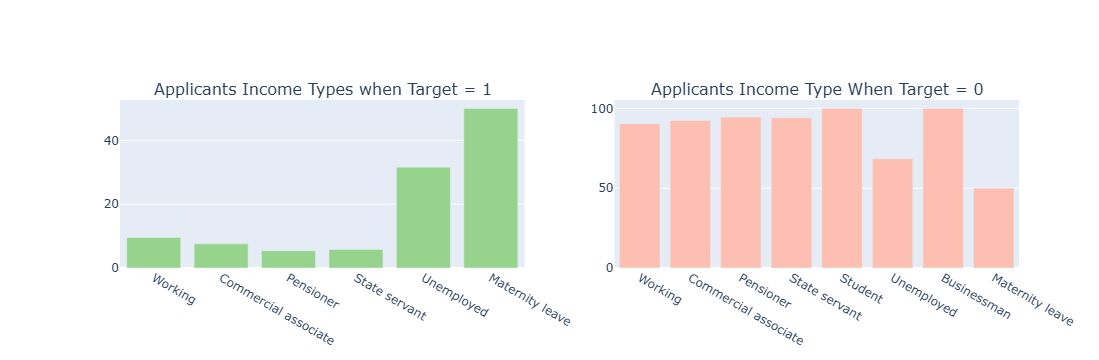

In [12]:
tr1, tr2 = gp('NAME_TYPE_SUITE', 'Applicants Type Suites which repayed the loan')
fig = make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Type Suites distribution when Target = 1", "Applicants Type Suites distribution when Target = 0"])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120))
iplot(fig)


tr1, tr2 = gp('NAME_INCOME_TYPE', 'Applicants Income Types which repayed the loan')
fig = make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Income Types when Target = 1", "Applicants Income Type When Target = 0"])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120))
iplot(fig)

We see that Applicants having Income Types : Maternity Leaves and UnEmployed has the highest percentage (about 50% and 31% approx) of Target = 1 (these applicant groups may having more payment problems), while Pensioners have the least (about 5.3%). 

### <a id="1.6">1.6. Applicant's Contract Type</a>

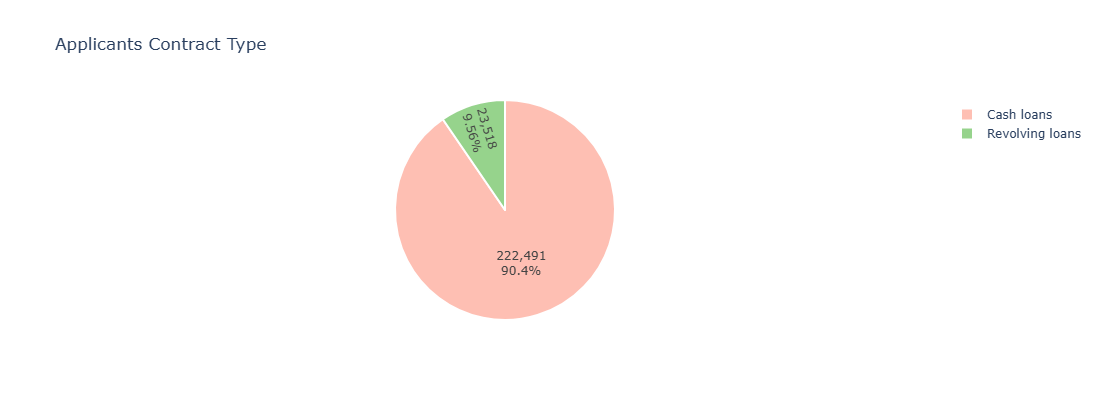

In [13]:
t = data['application_train']['NAME_CONTRACT_TYPE'].value_counts()
labels = t.index
values = t.values
colors = ['#FEBFB3','#96D38C']
trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value+percent',
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))
layout = go.Layout(title='Applicants Contract Type', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Cash loans with about 222K loans contributes to a majorty of total lonas in this dataset. Revolving loans has significantly lesser number equal to about 23K as compared to Cash loans. 

### <a id="1.7">1.7 Education Type and Housing Type </a>

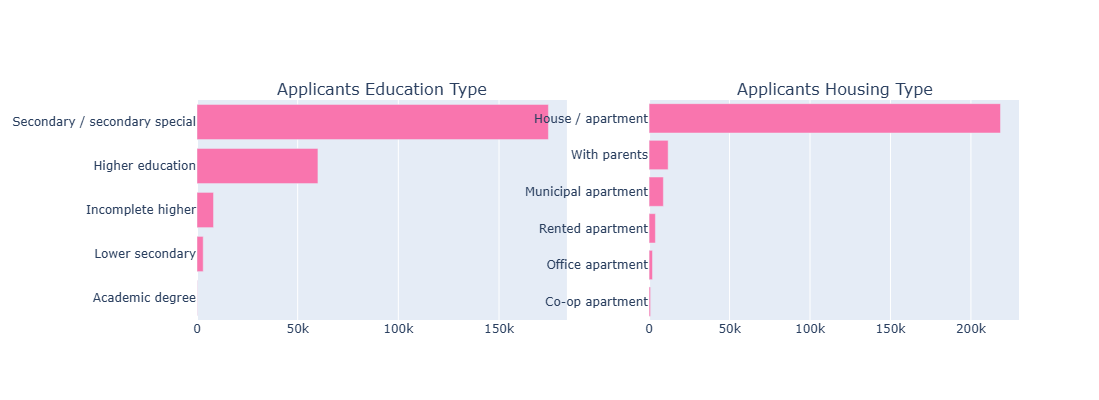

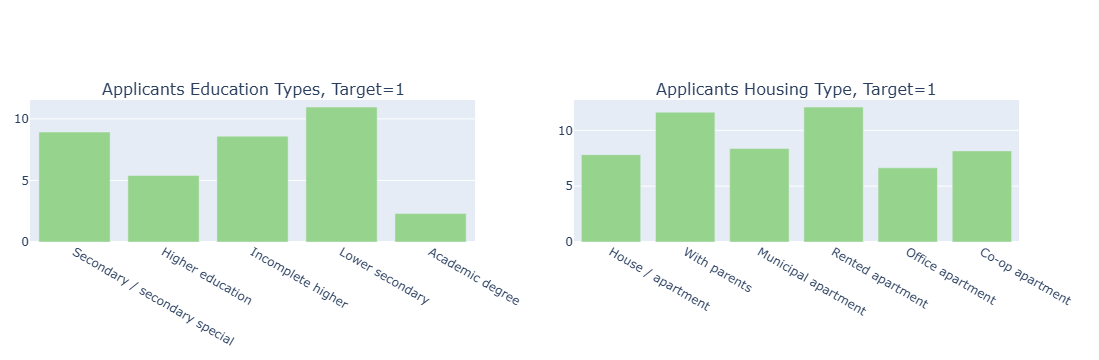

In [14]:
tr1 = bar_hor(data['application_train'], "NAME_EDUCATION_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace= True)
tr2 = bar_hor(data['application_train'], "NAME_HOUSING_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace = True)

fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Education Type', 'Applicants Housing Type' ])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig)


tr1, tr2 = gp('NAME_EDUCATION_TYPE', 'Applicants Income Types which repayed the loan')
tr3, tr4 = gp('NAME_HOUSING_TYPE', 'Applicants Income Types which repayed the loan')
fig = make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Education Types, Target=1", "Applicants Housing Type, Target=1"])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr3, 1, 2)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=30));
iplot(fig)

A large number of applications (174K) are filed by people having secondary education followed by people with Higher Education with 60K applications. Applicants living in House / apartments has the highest number of loan apllications equal to 218K. While we see that the applicants with Lower Secondary education status has the highest percentage of payment related problems. Also, Applicants living in apartments or living with parents also shows the same trend. 

### <a id="1.8">1.8. Which Organization and Occupation Type applies for loan and which repays </a>

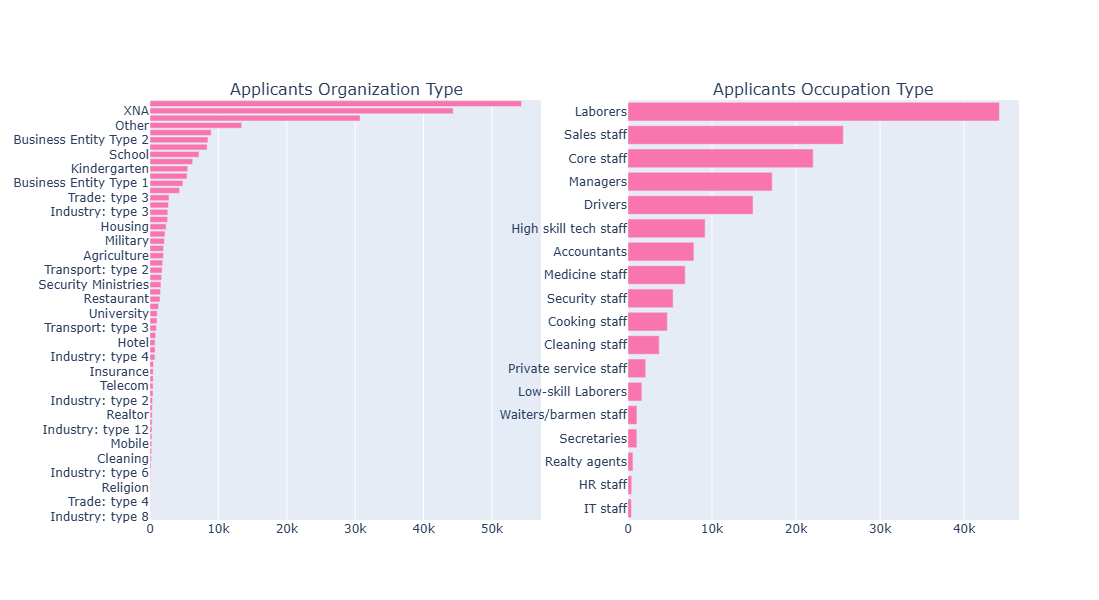

In [15]:
tr1 = bar_hor(data['application_train'], "ORGANIZATION_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace= True)
tr2 = bar_hor(data['application_train'], "OCCUPATION_TYPE", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace = True)
fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Organization Type', 'Applicants Occupation Type' ])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=600, showlegend=False, margin=dict(l=150))
iplot(fig)

Top Applicant's who applied for loan : Laborers - Approx 44 K, Sales Staff - Approx 25 K, Core staff - Approx 22 K. Entity Type 3 type organizations have filed maximum number of loans equal to approx 54K

### <a id="1.8.1">1.8.1 Target Variable with respect to Organization and Occupation Type </a>

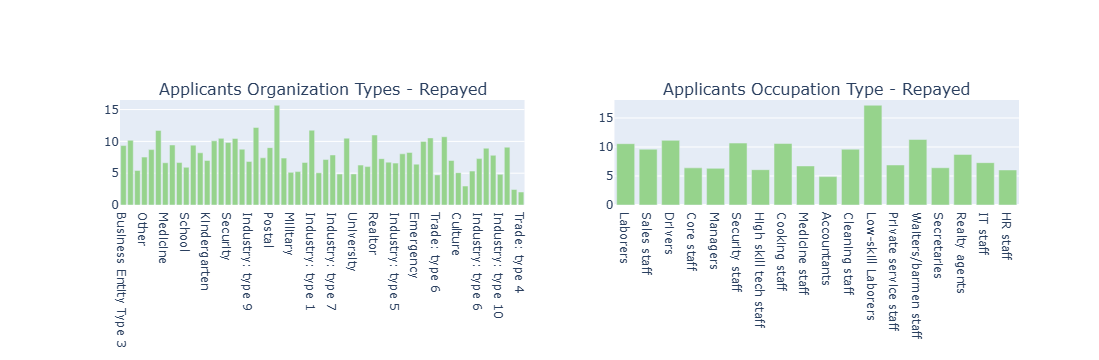

In [16]:
tr1, tr2 = gp('ORGANIZATION_TYPE', 'Applicants Income Types which repayed the loan')
tr3, tr4 = gp('OCCUPATION_TYPE', 'Applicants Income Types which repayed the loan')
fig = make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Organization Types - Repayed", "Applicants Occupation Type - Repayed"])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr3, 1, 2)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120))
iplot(fig)

### <a id="1.9">1.9 Walls Material, Foundation, and House Type </a>

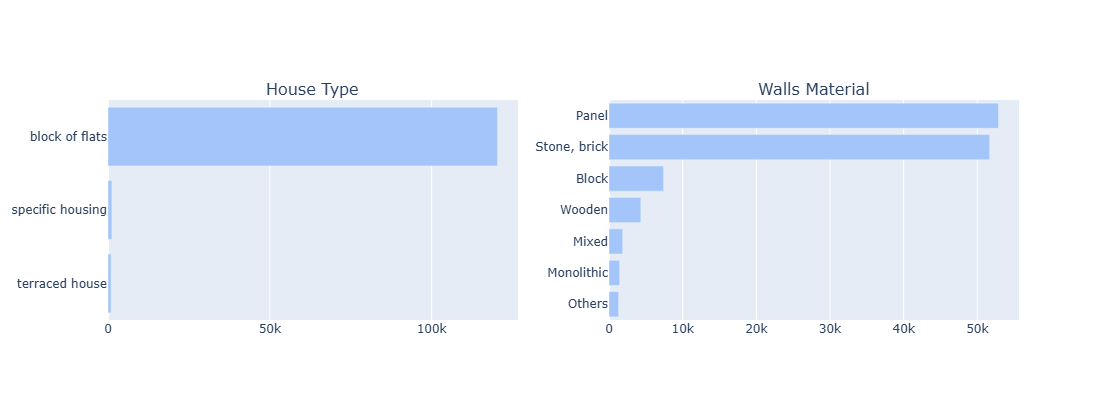

In [17]:
tr1 = bar_hor(data['application_train'], "FONDKAPREMONT_MODE", "Distribution of FLAG_OWN_REALTY" ,"#639af2", w=700, lm=100, return_trace= True)
tr2 = bar_hor(data['application_train'], "WALLSMATERIAL_MODE", "Distribution of FLAG_OWN_CAR" ,"#a4c5f9", w=700, lm=100, return_trace = True)
tr1 = bar_hor(data['application_train'], "HOUSETYPE_MODE", "Distribution of FLAG_OWN_CAR" ,"#a4c5f9", w=700, lm=100, return_trace = True)

fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = [ 'House Type', 'Walls Material'])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
# fig.append_trace(tr3, 1, 3);

fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig)

"Blocks and Flats" related house types have filed the largest number of loan applications equal to about 120K, rest of the other categories : Specific Housing and Terraced house have less than 1200 applications. Similarly houses having Panel and Stone Brick type walls material have filed the largest applciations close to 100K combined. 

### <a id="1.9.1">1.9.1 Target Variable with respect to Walls Material, Fondkappremont, House Type </a>

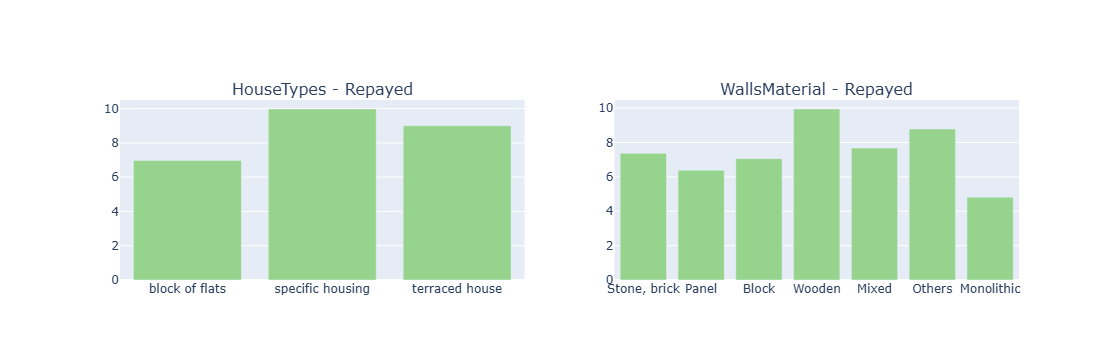

In [18]:
tr1, tr2 = gp('HOUSETYPE_MODE', 'Applicants Income Types which repayed the loan')
tr3, tr4 = gp('WALLSMATERIAL_MODE', 'Applicants Income Types which repayed the loan')
fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ["HouseTypes - Repayed", "WallsMaterial - Repayed"])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr3, 1, 2)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120))
iplot(fig)

### <a id="1.10">1.10. Distribution of Amount Credit </a>

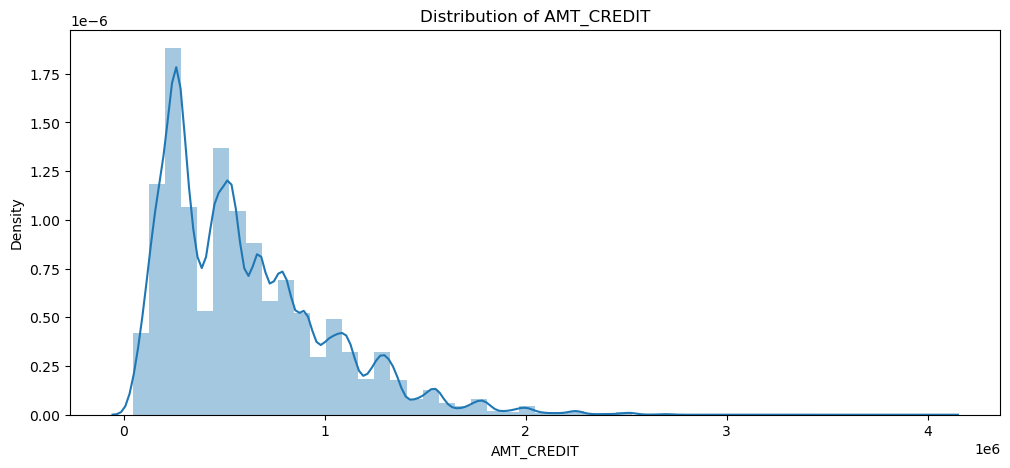

In [19]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(data['application_train']["AMT_CREDIT"])

### <a id="1.11">1.11 Distribution of Amount AMT_ANNUITY </a>

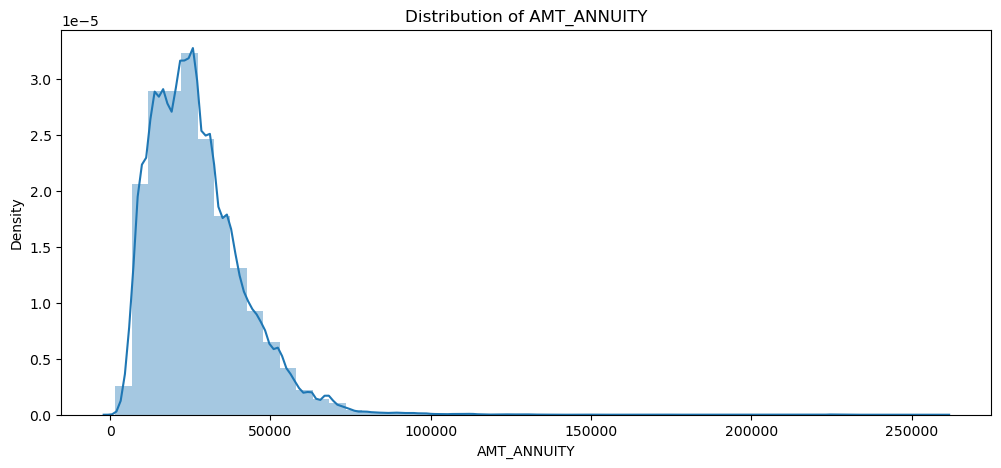

In [20]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_ANNUITY")
ax = sns.distplot(data['application_train']["AMT_ANNUITY"].dropna())

### <a id="1.12">1.12 Distribution of Amount AMT_GOODS_PRICE </a>

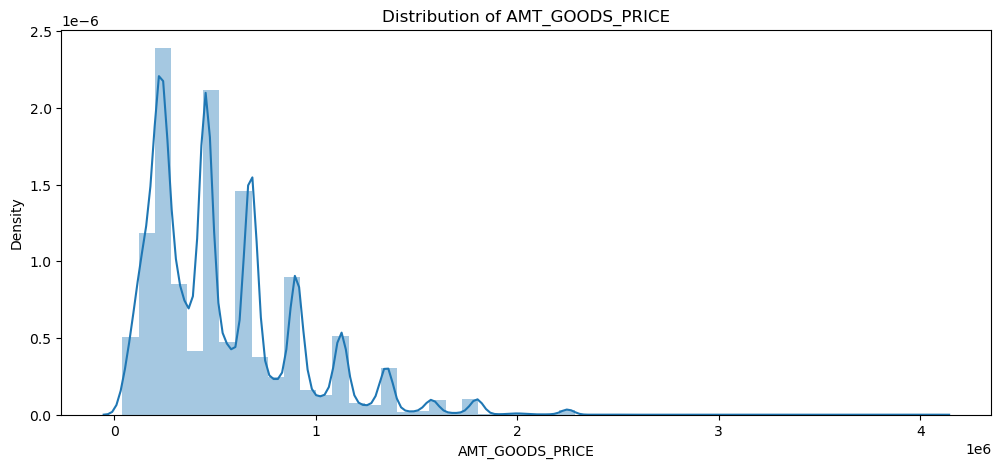

In [21]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(data['application_train']["AMT_GOODS_PRICE"].dropna())

### <a id="1.13">1.13 Distribution of Amount REGION_POPULATION_RELATIVE </a>

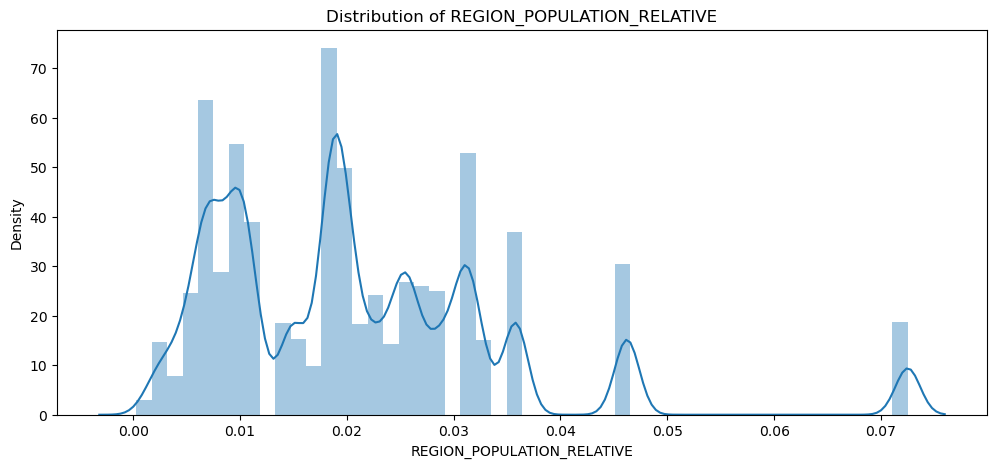

In [22]:
plt.figure(figsize=(12,5))
plt.title("Distribution of REGION_POPULATION_RELATIVE")
ax = sns.distplot(data['application_train']["REGION_POPULATION_RELATIVE"])

### <a id="1.14">1.14 Distribution of Amount DAYS_BIRTH </a>

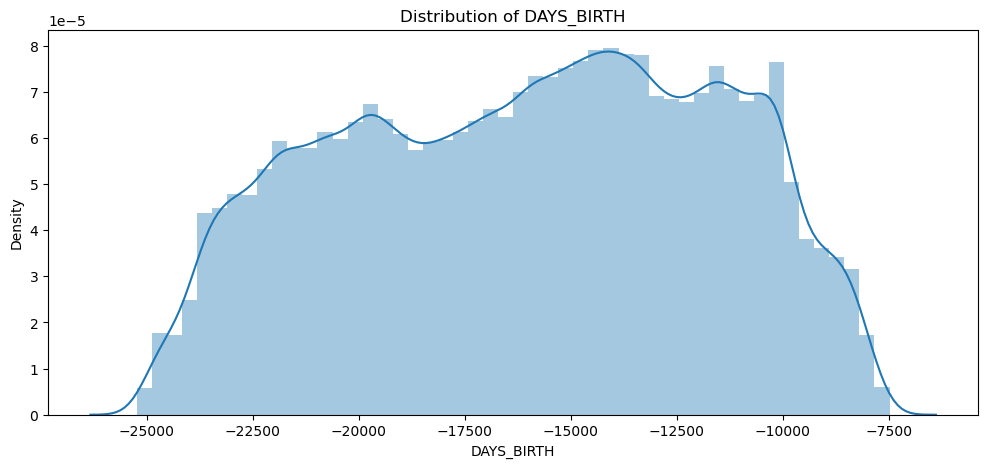

In [23]:
plt.figure(figsize=(12,5))
plt.title("Distribution of DAYS_BIRTH")
ax = sns.distplot(data['application_train']["DAYS_BIRTH"])

### <a id="1.15">1.15 Distribution of Amount DAYS_EMPLOYED </a>

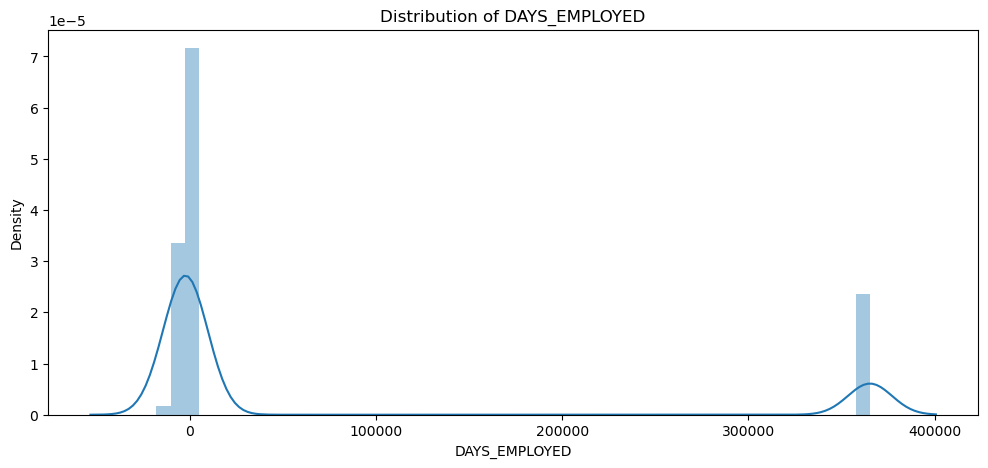

In [24]:
plt.figure(figsize=(12,5))
plt.title("Distribution of DAYS_EMPLOYED")
ax = sns.distplot(data['application_train']["DAYS_EMPLOYED"])

### <a id="1.16">1.16 Distribution of Number of Days for Registration</a>

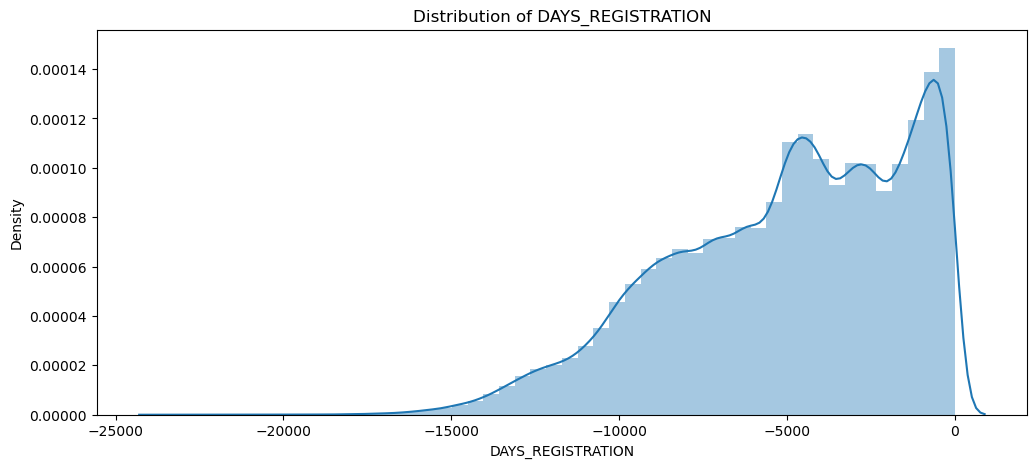

In [25]:
plt.figure(figsize=(12,5))
plt.title("Distribution of DAYS_REGISTRATION")
ax = sns.distplot(data['application_train']["DAYS_REGISTRATION"])

### <a id="1.17">1.17 How many Family Members does the applicants has </a>

Text(0.5, 0, '')

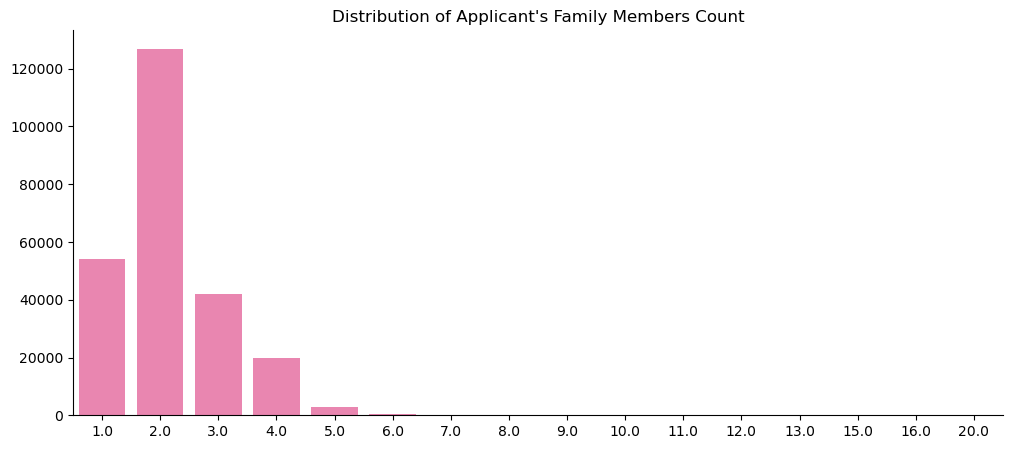

In [26]:
t = data['application_train']["CNT_FAM_MEMBERS"].value_counts()
t1 = pd.DataFrame()
t1['x'] = t.index 
t1['y'] = t.values 

plt.figure(figsize=(12,5));
plt.title("Distribution of Applicant's Family Members Count")
ax = sns.barplot(data=t1, x="x", y="y", color="#f975ae")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('')  
ax.set_xlabel('')

Most of the applicants who applied for loan had 2 family members in total


### <a id="1.18"> 1.18 How many Children does the applicants have </a>

Text(0.5, 0, '')

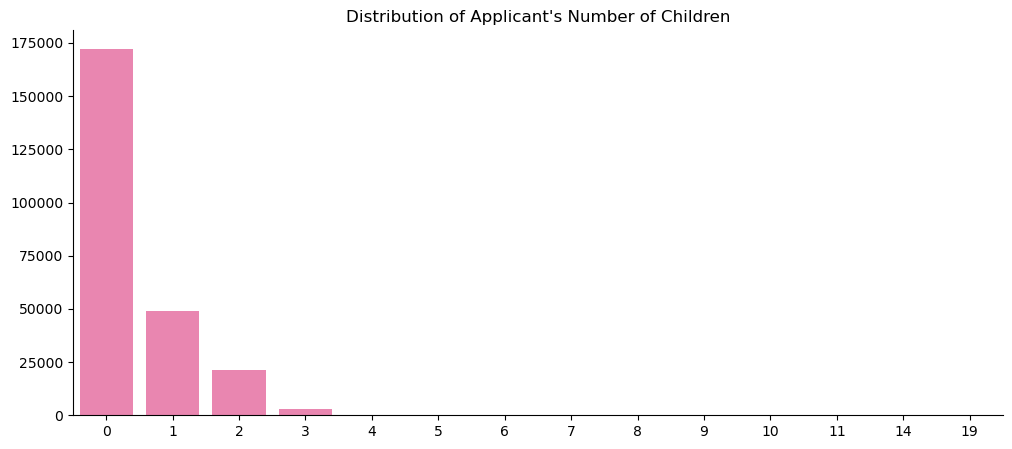

In [27]:
t = data['application_train']["CNT_CHILDREN"].value_counts()
t1 = pd.DataFrame()
t1['x'] = t.index 
t1['y'] = t.values 

plt.figure(figsize=(12,5))
plt.title("Distribution of Applicant's Number of Children")
ax = sns.barplot(data=t1, x="x", y="y", color="#f975ae")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('')   
ax.set_xlabel('')

A large majority of applicants did not had children when they applied for loan

## <a id="2">2. Exploration of Bureau </a>

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### <a id="2.1">2.1 Snapshot of Bureau Data</a>

In [28]:
data['bureau'].head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629


## <a id="3">3. Bureau Balance </a>

Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau rows.

### <a id="3.1">3.1 Snapshot of Bureau Balance </a>

In [29]:
data['bureau_balance'].head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


## <a id="4">4. Credit Card Balance</a>

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample rows.

### <a id="4.1">4.1 Snapshot of Credit Card Balance</a>

In [30]:
data['credit_card_balance'].head()

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.0,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0,87788
1,2582071,-82,16809.210,67500,0.0,0.0,0.0,0.0,3375.0,9000.0,9000.0,15488.685,16809.210,16809.210,0.0,0,0.0,0.0,18.0,Active,0,0,87788
2,2582071,-84,27577.890,67500,0.0,0.0,0.0,0.0,3375.0,4500.0,4500.0,26125.020,27577.890,27577.890,0.0,0,0.0,0.0,16.0,Active,0,0,87788
3,2582071,-7,65159.235,45000,0.0,0.0,0.0,0.0,2250.0,2250.0,2250.0,60301.170,65609.235,65609.235,0.0,0,0.0,0.0,63.0,Active,0,0,87788
4,2582071,-59,70475.850,67500,24750.0,24750.0,0.0,0.0,3375.0,4500.0,4500.0,63975.015,70475.850,70475.850,4.0,4,0.0,0.0,41.0,Active,0,0,87788


## <a id="5">5. POS CASH Balance Data</a>

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample rows.

### <a id="5.1">5.1 Snapshot of POS CASH Balance Data</a>

In [31]:
data['POS_CASH_balance'].head()

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,1803195,-31,48.0,45.0,Active,0,0,185279
1,1803195,-17,48.0,31.0,Active,0,0,185279
2,1803195,-21,48.0,35.0,Active,0,0,185279
3,1803195,-8,48.0,21.0,Active,0,0,185279
4,1803195,-4,48.0,17.0,Active,0,0,185279


## <a id="6">6. Previous Application</a>

### <a id="6.1">6.1 Snapshot of Prev Application</a>

In [32]:
data['previous_application'].head()

,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_CURR
0,2030495,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,293189
1,1696966,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18,Y,1,0.101325,NaN,NaN,XAP,Refused,-472,Cash through the bank,SCO,NaN,Repeater,Clothing and Accessories,POS,XNA,Regional / Local,55,Furniture,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,293189
2,2154916,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14,Y,1,0.000000,NaN,NaN,XAP,Approved,-548,Cash through the bank,XAP,NaN,New,Furniture,POS,XNA,Stone,196,Furniture,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,293189
3,2802425,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,91587
4,1536272,Cash loans,21709.125,450000.0,512370.0,NaN,450000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-515,XNA,XAP,NaN,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),6,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-485.0,565.0,-155.0,-147.0,1.0,91587


### <a id="6.2">6.2 Contract Status Distribution in Previously Filed Applications</a>

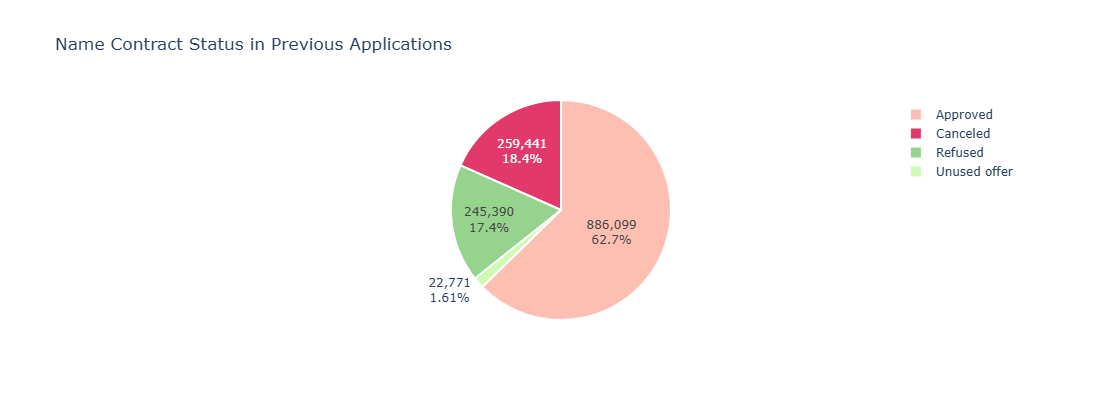

In [33]:
t = data['previous_application']['NAME_CONTRACT_STATUS'].value_counts()
labels = t.index
values = t.values

colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value+percent',
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))

layout = go.Layout(title='Name Contract Status in Previous Applications', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

A large number of people (about 62.7%) had their previous applications approved, while about 18.4% of them had cancelled and other 17.4% were resued. 

### <a id="6.3">6.3 Suite Type Distribution of Previous Applications</a>

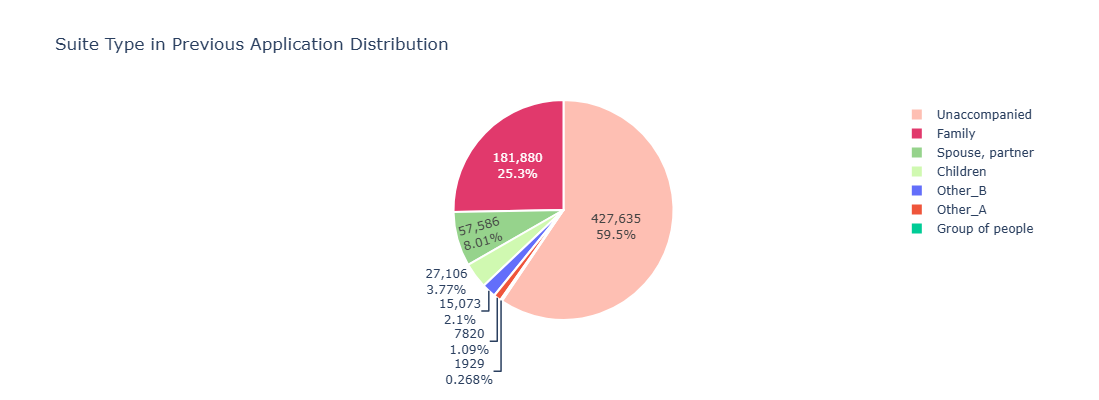

In [34]:
t = data['previous_application']['NAME_TYPE_SUITE'].value_counts()
labels = t.index
values = t.values

colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value+percent',
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))

layout = go.Layout(title='Suite Type in Previous Application Distribution', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

A majority of applicants had previous applications having Unaccompanied Suite Type (about 60%) followed by Family related suite type (about 25%)

### <a id="6.4">6.4 Client Type of Previous Applications</a>

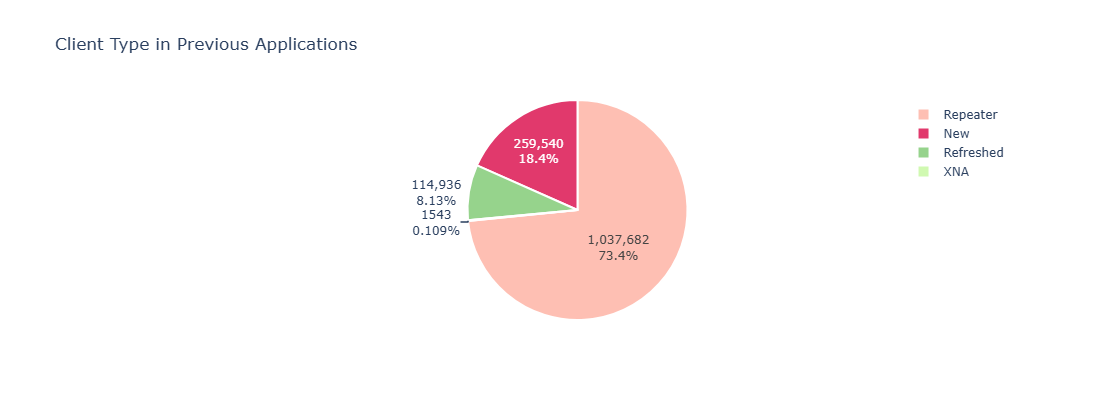

In [35]:
t = data['previous_application']['NAME_CLIENT_TYPE'].value_counts()
labels = t.index
values = t.values

colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value+percent',
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))

layout = go.Layout(title='Client Type in Previous Applications', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

 About 74% of the previous applications were Repeater Clients, while only 18% are new. About 8% are refreshed. 

### <a id="6.5">6.5 Channel Type - Previous Applications </a>

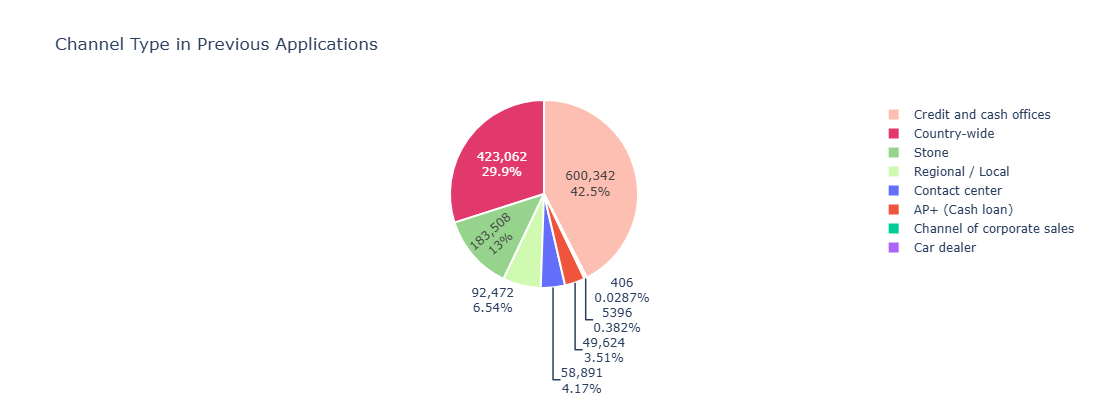

In [36]:
t = data['previous_application']['CHANNEL_TYPE'].value_counts()
labels = t.index
values = t.values

colors = ['#FEBFB3', '#E1396C', '#96D38C', '#D0F9B1']

trace = go.Pie(labels=labels, values=values,
               hoverinfo='label+percent', textinfo='value+percent',
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))

layout = go.Layout(title='Channel Type in Previous Applications', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## <a id="7">7. Installation Payments </a>

### <a id="7.1">7.1 Snapshot of Installation Payments </a>

In [37]:
data['installments_payments'].head()

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0
